## Data generation and analysis

This notebook analyzes the data used for training the models. Data generation and training have been done following and running all the steps described in [INSTRUCTIONS.MD](https://github.com/wenhao-gao/SynNet/blob/master/INSTRUCTIONS.md) on the original repository (using the scripts provided in the 'scripts' folder).

## Environment Setup
First of all, we need to make sure that the notebook is running in the correct environment.

To do that, follow these steps:
 1. Create the project's environment
    To do that, place yourself in the project's root, and run :
    `conda env create -f environment.yml`
    This creates a new clean conda environment with the package needed by the project.
 2. Activate the environment
    On Linux and Mac:
    `source activate synnet`
    On Windows:
    `conda activate synnet`
 3. Install the project's module
    Now that the environment is activated, we need to install the project as a module.
    Place yourself in the project's root and run :
    `pip install -e .`
 4. Restart Jupyter from the new environment
    Now, we can start Jupyter from the environment, that way it has all the dependencies we need. Simply run `jupyter notebook` and open this notebook.

To test the setup, run the following cell.

In [1]:
import sys

# Check that the correct conda env is being used
if sys.prefix.split("\\")[-1] != "synnet":
    print(
        "You are not using the correct conda environment, please follow the instructions above"
    )
else:
    try:
        import synnet

        print("The environment is setup correctly")
    except ImportError:
        print(
            "The module 'synnet' is not installed, please follow the instructions above"
        )

You are not using the correct conda environment, please follow the instructions above


### Tree generation and splitting

Synthetic trees describe the chemical synthesis of one molecule. These data are key because they are fed to the model, determining its accuracy. First, we download the filtered synthetic trees sets. These files contain around 450000 synthetic trees that have been generated using scripts 03 (03-generate-syntrees.py), filtered using script 04 (04-filter-trees.py) to obtain trees containing drug-like molecule roots, and splitted into train, validation and test sets using script 05 (05-split-syntrees.py).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt
from helpers.loader import get_filtered_syntrees, get_featurized_syntrees

/home/sabanza/miniconda3/envs/synnet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load each set and check number of trees contained.

In [4]:
trees_dict = get_filtered_syntrees()

train = trees_dict["train"]
test = trees_dict["test"]
valid = trees_dict['valid']
syntrees = trees_dict.items()

print("Loaded content :\n")

for name, trees in syntrees:
    print(f"{name} set contains {len(trees)} trees")

train.json.gz is already present, no need to download it
valid.json.gz is already present, no need to download it
test.json.gz is already present, no need to download it
Loaded content :

train set contains 269322 trees
valid set contains 89774 trees
test set contains 89775 trees


A synthetic tree is formed by a dictionary containing different keys: reactions, chemicals, depth, actions and rxn_id2type. By analyzing feature distribution on each tree set, we can check if all sets have the same data distribution.

In [5]:
# Check one tree structure
print(train[0])

{'reactions': [{'rxn_id': 38, 'rtype': 2, 'parent': 'COc1ccc(C=C(C)S(=O)(=O)NC(C)c2cc(OC)ccc2O)cc1', 'child': ['COc1ccc(O)c(C(C)N)c1', 'COc1ccc(C=C(C)S(=O)(=O)Cl)cc1'], 'depth': 0.5, 'index': 0}], 'chemicals': [{'smiles': 'COc1ccc(O)c(C(C)N)c1', 'parent': 38, 'child': None, 'is_leaf': True, 'is_root': False, 'depth': 0, 'index': 0}, {'smiles': 'COc1ccc(C=C(C)S(=O)(=O)Cl)cc1', 'parent': 38, 'child': None, 'is_leaf': True, 'is_root': False, 'depth': 0, 'index': 1}, {'smiles': 'COc1ccc(C=C(C)S(=O)(=O)NC(C)c2cc(OC)ccc2O)cc1', 'parent': None, 'child': 38, 'is_leaf': False, 'is_root': True, 'depth': 1, 'index': 2}], 'root': {'smiles': 'COc1ccc(C=C(C)S(=O)(=O)NC(C)c2cc(OC)ccc2O)cc1', 'parent': None, 'child': 38, 'is_leaf': False, 'is_root': True, 'depth': 1, 'index': 2}, 'depth': 1, 'actions': [0, 3], 'rxn_id2type': None}


### Data distribution

We check tree depth distribution for each set. Tree depth determines the complexity of the synthesis (the more steps a synthesis has, the more challenging it is). Therefore, we would like to know how the different synthesis are distributed and their complexity distribution.

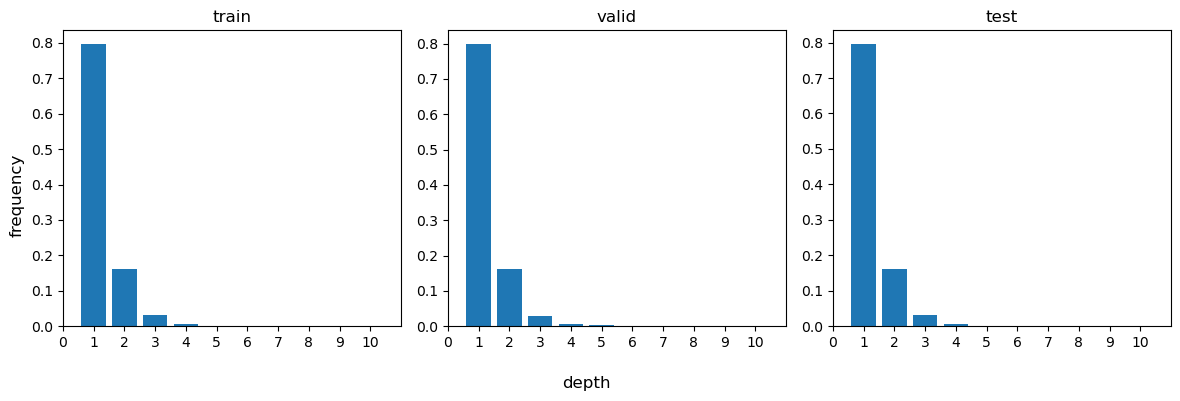

In [6]:
# Plot tree depth frequency for each set
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (name, trees) in enumerate(syntrees):
    depth = [int(tree["depth"]) for tree in trees]
    depth = pd.Series(depth)
    counts = depth.value_counts(normalize=True)
    ind = counts.index
    freq = counts.values

    ax[i].bar(ind, freq)
    ax[i].set_xlim((0, 11))
    ax[i].set_xticks(list(range(0, 11)))
    ax[i].set_title(name)

fig.supylabel("frequency")
fig.supxlabel("depth")
fig.tight_layout()

From these figures we can observe that the distribution is similar in the three sets. There is a predominance of depth = 1 trees

We can also analyze how actions are distributed in all trees. Actions are also related to the synthetic pathways (for example, higher number of expand actions would mean more challenging synthesis)

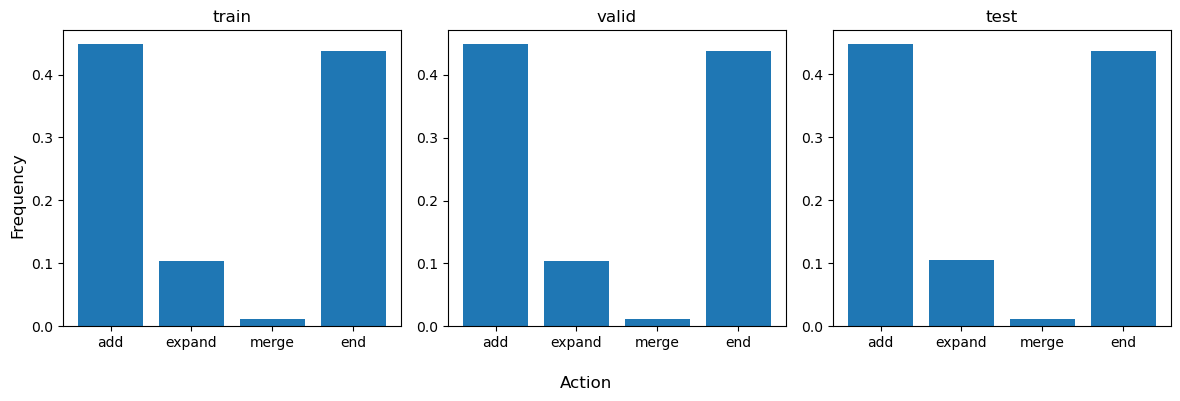

In [7]:
# Plot tree action frequency for each set
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (name, trees) in enumerate(syntrees):
    actions = [tree["actions"] for tree in trees]
    actions = [act for group in actions for act in group]
    actions = pd.Series(actions)
    counts = actions.value_counts(normalize=True)
    ind = counts.index
    freq = counts.values
    ax[i].bar(ind, freq)
    ax[i].set_xticks(ticks=[0, 1, 2, 3], labels=["add", "expand", "merge", "end"])
    ax[i].set_title(name)

fig.supylabel("Frequency")
fig.supxlabel("Action")
fig.tight_layout()

We again observe the same distribution in all sets. Actions 1 and 2 have a joint frequency lower than 0.15, meaning that the majority of trees won't be branched 

Finally, we check root products (stored as SMILES in each tree). We use molar weight as an approximate measure of product complexity distribution, checking molar weight distribution for each set.

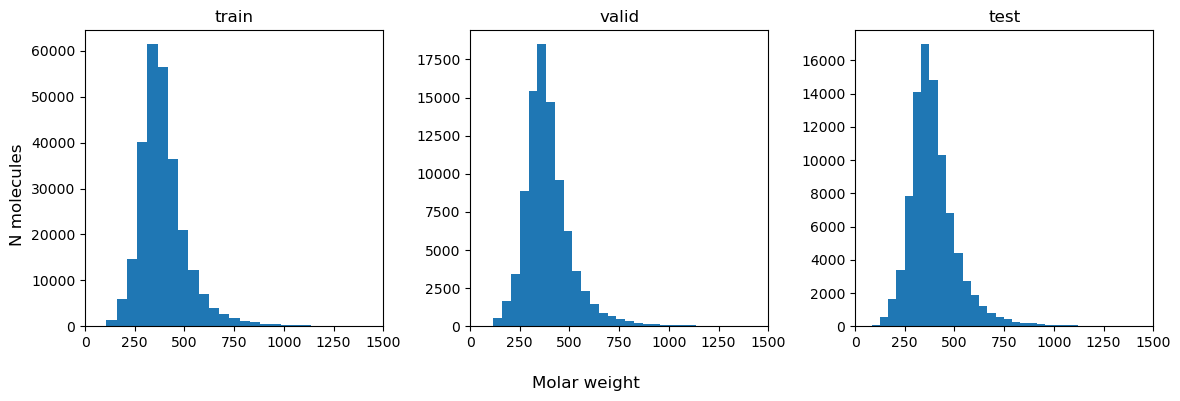

In [8]:
# Plot tree action frequency for each set
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (name, trees) in enumerate(syntrees):
    smiles = [tree["root"]["smiles"] for tree in trees]
    mw = [MolWt(Chem.MolFromSmiles(smile)) for smile in smiles]

    ax[i].hist(mw, bins=50)
    ax[i].set_xlim(0, 1500)
    ax[i].set_title(name)

fig.supylabel("N molecules")
fig.supxlabel("Molar weight")
fig.tight_layout()

Molar weights are similarly distributed on the three sets, showing that the majority of root molecules have a value between 250 and 500.

The previous graphs show that synthetic tree data are similar for the three sets, and therefore we can conclude that data (root molecules, synthetic steps and applied reactions) will have the same distribution in the three cases. We thus expect that the model will build root molecules from the test set (reachable) easier than molecules coming from a different data distribution (like ChEMBL dataset).

### Tree featurization

After tree generation, we featurize them using scripts 06 (06-featurize-syntrees.py). Featurization splits each tree in the corresponding synthetic steps and creates a vector embedding representing the state of the tree (this data can be fed to each MLP to train the model). Besides, we split the features into the corresponding actions to fed each type of network using script 07 (07-split-data-for-networks.py).

Featurized data can be downloaded by running the cell below.

In [4]:
get_featurized_syntrees()

These data are used to train each MLP from scratch by running the corresponding scripts stored on src/synnet/models/. The resulting trained network are used in run.ipynb for synthesis planning and result evaluation.